In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Flatten image and remove walls

In [3]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

# max_env_steps = 100

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) ,), 
            dtype='uint8'
        )
        # self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        x = (flattened_grid[0::3] == 10).astype(int)
        y = flattened_grid[2::3] + 1
        return x/y
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

# Worker agent

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
from torch.distributions.multivariate_normal import MultivariateNormal

BATCH_SIZE = 128 # 128
UPDATE_STEP = 4 # 4
BUFFER_SIZE = 100000 # 100000
LEARNING_RATE = 5e-3 # 5e-3
GAMMA = 0.9 # 0.9
EPS_START = 1 # 1
EPS_END = 0.1 # 0.1
EPS_DECAY = 0.995 # 0.995
TAU=1e-3 # 1e-3
EPSILON = 0.2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
    
    
class WorkerNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, action_size, emb_size=32, seed=42, hidden_size1=64, hidden_size2=64):
        super(WorkerNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer11 = nn.Linear(state_size, hidden_size1)
        self.layer12 = nn.Linear(state_size, emb_size)
        self.layer2 = nn.Linear(hidden_size1 + emb_size, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, action_size)

    def forward(self, states, goal_states, emb=None):
        x = F.relu(self.layer11(states))
        if emb is None:
            emb = F.relu(self.layer12(goal_states))
        x = torch.cat((emb, x), 1)
        x = F.relu(self.layer2(x))
        return F.relu(self.layer3(x))
    

class DQNAgentWorker:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, action_size, pretrain=True, emb_size=32, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.qnetwork_local = WorkerNetwork(state_size, action_size).to(device)
        self.qnetwork_target = WorkerNetwork(state_size, action_size).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        self.action_size = action_size
        self.buffer = deque(maxlen=BUFFER_SIZE) 
        self.step = 0
        self.eps = EPS_START
        self.explore = True
            
   
    def reset_episode(self):
        """
        Resets episode and update epsilon decay
        """
        self.eps = max(EPS_END, EPS_DECAY*self.eps) 
        
        
    def learn(self):
        """
        Learns values-actions network
        
        """
        
        # Sample batch from replay buffer
        states, next_states, goal_states, actions, rewards, dones = self.sample_batch()
            
        values = self.qnetwork_target.forward(next_states, goal_states).detach()
        targets = rewards + GAMMA * values.max(1)[0].view(dones.size()) * (1 - dones)
        outputs = self.qnetwork_local.forward(states, goal_states)
        outputs = outputs.gather(1, actions.long())
                
        self.optimizer.zero_grad()
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()

            
            
    def update(self, state, goal_state, action, reward, next_state, done):
        """
        Makes an update step of algorithm and append sars to buffer replay
        
        Params:
        -------
        state - current state
        action - action made
        reward - reward for an action
        next_state - next state from env
        done - episode finishing flag
        """
        self.buffer.append((state, next_state, goal_state, action, reward, float(done)))
        
        self.step = (self.step+1)%UPDATE_STEP
        if self.step == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
                self.reset_target_network()
        
        
    def reset_target_network(self):
        """
        Resets params of target network to values from local network
        """
        params = zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters())
        for target_param, local_param in params:
            updated_params = TAU*local_param.data + (1-TAU)*target_param.data
            target_param.data.copy_(updated_params)
        
        
    def act(self, state, goal_state, goal_emb=None):
        """
        Selects action from state if epsilon-greedy way
        
        Params:
        state - current state
        
        """
        
        
        self.step+=1
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(torch.from_numpy(np.vstack([state])).float().to(device), 
                                                None if goal_state is None else torch.from_numpy(np.vstack([goal_state])).float().to(device),
                                                goal_emb)  
        self.qnetwork_local.train()
            
        if (random.random() > self.eps) and self.explore:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def sample_batch(self):
        """
        Samples a batch of experience from replay buffer random uniformily
        """
        batch = random.sample(self.buffer, k=BATCH_SIZE)
        f = lambda arr: torch.from_numpy(np.vstack(arr)).float().to(device)
        states, next_states, goal_states, actions, rewards, dones = map(f, zip(*batch))
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        return states, next_states, goal_states, actions, rewards, dones

Running on device: cpu


# Master agent

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
from torch.distributions.multivariate_normal import MultivariateNormal

BATCH_SIZE = 128 # 128
UPDATE_STEP = 1 # 4
BUFFER_SIZE = 100000 # 100000
LEARNING_RATE_MASTER = 1e-3 # 5e-4
GAMMA = 0.9 # 0.9
EPS_START = 1 # 1
EPS_END = 0.1 # 0.1
EPS_DECAY = 0.995 # 0.995
TAU=1e-3 # 1e-3
EPSILON = 0.2 # 0.2
EPOCHS = 1
LAMBDA = 0.8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

    
class MasterNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """
    
    def __init__(self, state_size, emb_size=32, seed=42, hidden_size1=64, hidden_size2=64):
        super(MasterNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.mu = nn.Linear(hidden_size2, emb_size)
        self.sigma = nn.Linear(hidden_size2, emb_size) 

    def forward(self, states, goal_emb=None):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        mu = F.relu(self.mu(x))
        cov = F.softplus(F.relu(self.sigma(x)))
        cov = torch.diag_embed(cov) # Distibute covariances
        state_dist = MultivariateNormal(mu, cov)
        
        if goal_emb is None:
            goal_emb = state_dist.sample()
            
        state_log_probs = state_dist.log_prob(goal_emb)
        entropy = state_dist.entropy()
            
        return state_log_probs, entropy, goal_emb.detach()
    
    def sample_goal(self, states):
        with torch.no_grad():
            _, _, goal_emb =  self.forward(states, None)
            return goal_emb
    
    
class CriticNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, 1)

    def forward(self, states):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
class MasterCriticNetwork(nn.Module):
    """
    Master-Worker model
    """
    
    def __init__(self, state_size, pretrain=True, seed=42):
        super(MasterCriticNetwork, self).__init__()
        self.pretrain = pretrain
        self.master = MasterNetwork(state_size)
        self.critic = CriticNetwork(state_size)
        
    def forward(self, states, goal_embs=None):
        state_log_probs, entropy, _ = self.master.forward(states, goal_embs)
        return self.critic.forward(states), state_log_probs, entropy
    
class Memory():
    """
    Memory buffer for saving trajectories
    """
    
    def __init__(self):
        self.states = []
        self.goal_states = []
        self.next_states = []
        self.rewards = []
        self.dones = []
    
    def clear(self):
        del self.states[:]
        del self.goal_states[:]
        del self.next_states[:]
        del self.rewards[:]
        del self.dones[:]
        
    def get_trajectory(self):
        to_torch = lambda arr: torch.from_numpy(np.array(arr)).to(device).float()
        states = to_torch(self.states)
        goal_states = to_torch(self.goal_states)
        next_states = to_torch(self.next_states)
        rewards = to_torch(self.rewards).reshape(-1, 1)
        dones = to_torch(self.dones).reshape(-1, 1)
        return states, goal_states, rewards, next_states, dones
    

class DQNAgentMaster:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, action_size, emb_size=32, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.qnetwork_local = MasterCriticNetwork(state_size).to(device)
        self.qnetwork_target = MasterCriticNetwork(state_size).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE_MASTER)
        self.action_size = action_size
        self.memory = Memory()
        self.step = 0
        self.eps = EPS_START
        self.explore = True
        self.T = 256 
        self.K_epochs = 10 
        
    def sample_goal(self, state):
        return self.qnetwork_target.master.sample_goal(state)
            
   
    def reset_episode(self):
        """
        Resets episode and update epsilon decay
        """
        self.eps = max(EPS_END, EPS_DECAY*self.eps) 
        
        
    def _compute_loss(self):
        """
        Learns values-actions network
        
        """
        
        # Sample batch from replay buffer
        states, goal_states, rewards, next_states, dones = self.memory.get_trajectory()
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)            
            
        values, goal_log_probs, S = self.qnetwork_local.forward(states, goal_states)
        
        with torch.no_grad():
            values_old, goal_log_probs_old, _ = self.qnetwork_target.forward(states, goal_states)
            values_old = values_old.detach()
            values_next_old, _, _ = self.qnetwork_target.forward(next_states, goal_states)
            values_next_old = values_next_old.detach()

        ratios = torch.exp(goal_log_probs - goal_log_probs_old)
        targets = rewards + GAMMA*values_next_old*(1-dones)
        advantages = targets - values_old
        
        s1 = ratios * advantages
        s2 = torch.clamp(ratios, 1 - EPSILON, 1 + EPSILON) * advantages
        loss_clip = torch.min(s1, s2).mean()  
        loss_vf = F.mse_loss(values, targets)
        loss_e = S.mean()
        loss = 0.01*loss_vf - loss_clip # - 0.001 * loss_e
        # print(loss_vf.item(), loss_clip.item()) # , loss_e.item())
        return loss
        
            
    
    def update(self, state, goal_state, action, reward, next_state, done):
        """
        Makes an update step of algorithm and append sars to buffer replay
        
        Params:
        -------
        state - current state
        action - action made
        reward - reward for an action
        next_state - next state from env
        done - episode finishing flag
        """
        if len(self.memory.states) < self.T:
            self.memory.states.append(state)
            self.memory.goal_states.append(goal_state)
            self.memory.rewards.append(reward)
            self.memory.next_states.append(next_state)
            self.memory.dones.append(done)
            return
        
        for _ in range(self.K_epochs):
            loss = self._compute_loss()
            self.optimizer.zero_grad()        
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.)
            self.optimizer.step()
        
        self.reset_target_network()      
        self.memory.clear()
        
        
    def reset_target_network(self):
        """
        Resets params of target network to values from local network
        """
        params = zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters())
        for target_param, local_param in params:
            updated_params = TAU*local_param.data + (1-TAU)*target_param.data
            target_param.data.copy_(updated_params)

Running on device: cpu


In [6]:
import gym

def to_coords(state):
    n = int(np.sqrt(len(state)))
    for i in range(n):
        for j in range(n):
            k = n*i + j
            if state[k] > 0:
                return np.array([i+1, j+1])
            

class RandomPosAndGoalWrapper(gym.Wrapper):
    
    def reset(self):
        
        # Generate goal state
        self.env.unwrapped.agent_pos = np.random.randint(1, self.grid_size-1, 2) 
        self.goal_state = self.env.observation(self.env.unwrapped.gen_obs())
        goal_pos = to_coords(self.goal_state)
        
        
        # Set initial state
        self.env.reset()
        radius = self.grid_size-2
        init_pos = (goal_pos + np.random.randint(0, radius, 2))%(self.grid_size-2) + 1
        while (init_pos==goal_pos).all():
            init_pos = (goal_pos + np.random.randint(0, radius, 2))%(self.grid_size-2) + 1\
            
        self.env.unwrapped.agent_pos = init_pos
        init_state = self.env.observation(self.env.unwrapped.gen_obs())
        # print(init_pos, goal_pos, init_state, self.goal_state, self.grid_size)
            
        
        
        # Return initial state 
        return init_state
    
    def __init__(self, env):
        self.goal_state = None
        self.grid_size = env.unwrapped.grid.encode().shape[0]
        super().__init__(env)
        
        
    def step(self, action):
        state = self.env.observation(self.env.unwrapped.gen_obs())
        next_state, reward, done, info = self.env.step(action)
        cur_pos, next_pos, goal_pos = to_coords(state), to_coords(next_state), to_coords(self.goal_state)
        dist1 = np.linalg.norm(cur_pos - goal_pos)
        dist2 = np.linalg.norm(next_pos - goal_pos)
        
        reward = (dist1 - dist2)
        reward = 1 - np.sqrt(2) if reward == 0 else reward
        
        if (next_pos == goal_pos).all() or (self.step_count  >= self.max_steps):
            done = True
        else: 
            done = False
        
        return next_state, reward, done, info
    
            
from gym.wrappers import Monitor

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    env = FlatObsWrapper(gym.make(env_name))
    env = RandomPosAndGoalWrapper(env)
    return wrap_env(env)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def run_episode(env, worker_agent, master_agent=None, train_mode=True, show_steps=False):
    """
    A hepler function for running single episode
    """
    
    state = env.reset() 
    if not train_mode:
        if master_agent is None:
            print("From ", to_coords(state), "to", to_coords(env.goal_state))
    score = 0 
    done = False
    
    steps = 0
        
    
    while not done:
        if master_agent is None:
            goal_state = env.goal_state
            action = worker_agent.act(state, goal_state)
            next_state, reward, done, _ = env.step(action)
            worker_agent.update(state, goal_state, action, reward, next_state, done)
            state = next_state
            score += reward  
            steps+=1
        else:
            s = torch.from_numpy(np.vstack([state])).float().to(device)
            goal_embs = master_agent.sample_goal(s)
            
            state_ = state
            for _ in range(1):
                action = worker_agent.act(state_, None, goal_embs)
                next_state, reward, done, _ = env.step(action)
                state_ = next_state
                score += reward  
                steps+=1
                if done:
                    break
            master_agent.update(state, goal_embs.cpu().data.numpy(), None, reward, next_state, done)
            state = next_state
                
                
        if (not train_mode) and show_steps:
            img = env.render('rgb_array')
            plt.imshow(img);
            plt.show()
        
            
    if master_agent is not None:
        master_agent.reset_episode()
    else:
        worker_agent.reset_episode()
    env.close()
    
    if not train_mode:
        show_video()
    
    return score, steps

def run_episodes_and_display(env, worker_agent, master_agent=None, n_episodes=1000):
    """
    Runs a series of episode and display agent's performance
    """
    
    display_step = 100
    score = 0
    score_sum = 0
    scores = []
    steps = []
    for episode in range(1, n_episodes+1):
        score, step = run_episode(env, worker_agent, master_agent, train_mode=True)
        score_sum += score
        scores.append(score)
        steps.append(step)
        if episode%display_step==0:
            avg_score = score_sum/display_step
            print("Episode: {}. Average score: {}".format(episode, avg_score))
            score_sum = 0
            
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Max Score')
    plt.xlabel('Episode #')
    plt.show()
    
    fig = plt.figure()
    plt.plot(np.arange(len(steps)), steps)
    plt.ylabel('Steps')
    plt.xlabel('Episode #')
    plt.show()

Episode: 100. Average score: -25.260552379874284
Episode: 200. Average score: -7.490239479954733
Episode: 300. Average score: -1.9970197402370846
Episode: 400. Average score: -2.183323018572778
Episode: 500. Average score: 0.08821155947387702
Episode: 600. Average score: -0.3312808264109161
Episode: 700. Average score: 0.02686249655094248
Episode: 800. Average score: -0.5835843239109858
Episode: 900. Average score: 0.7456654019277853
Episode: 1000. Average score: 1.7208852297464197


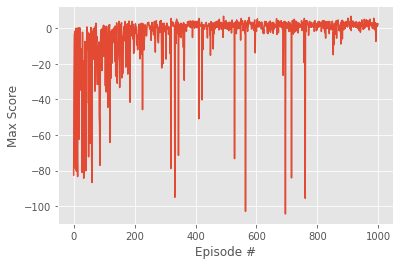

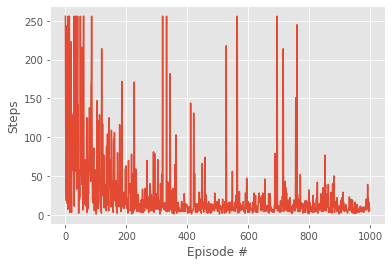

CPU times: user 1min 54s, sys: 1.01 s, total: 1min 55s
Wall time: 1min 55s


In [8]:
%%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = gen_wrapped_env(env_name)
state_size = env.observation_space.shape[0]
action_size = 3
worker_agent = DQNAgentWorker(state_size, action_size)
run_episodes_and_display(env, worker_agent, n_episodes=500)

In [9]:
env = gen_wrapped_env(env_name)
run_episode(env, worker_agent, train_mode=False, show_steps=False)

From  [6 2] to [2 1]


(2.880464938498375, 8)

# Learn exploring env and move to goal

Episode: 100. Average score: 0.24057421875000007
Episode: 200. Average score: 0.31825390624999994
Episode: 300. Average score: 0.2884843750000001
Episode: 400. Average score: 0.32472265624999996
Episode: 500. Average score: 0.2763632812499999


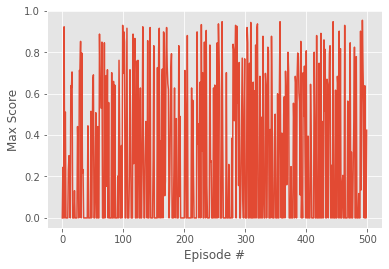

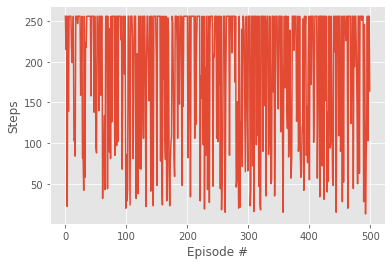

CPU times: user 9min 7s, sys: 4min 16s, total: 13min 24s
Wall time: 5min 51s


In [13]:
%%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = FlatObsWrapper(gym.make(env_name))
master_agent = DQNAgentMaster(state_size, action_size)
run_episodes_and_display(env, worker_agent, master_agent, n_episodes=500)

In [14]:
env = FlatObsWrapper(gym.make(env_name))
#env = CuriosityWrapper(env)
env = Monitor(env, './video', force=True)
run_episode(env, worker_agent, master_agent, train_mode=False, show_steps=False)

(0.89453125, 30)